# Setup

In [1]:
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import warnings
import os
import pandas as pd
import anndata as ad
import seaborn as sns

Global seed set to 0


In [2]:
sc.set_figure_params(figsize=(4,4),  dpi=150, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/notebook/Joe/M-cells/code/epithelial_signature_processing'

# Data import

Data from: https://www.cell.com/cell-stem-cell/fulltext/S1934-5909(20)30012-6 <br>
Accession link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE129218 <br>
GSE129218_barcodes_5w.tsv.gz <br>
GSE129218_barcodes_9w.tsv.gz <br>
GSE129218_genes_5w.tsv.gz <br>
GSE129218_genes_9w.tsv.gz <br>
GSE129218_matrix_5w.mtx.gz <br>
GSE129218_matrix_9w.mtx.gz <br>
Annotations for cell type labels: https://github.com/kasperlab/Joost_et_al_2020_Cell_Stem_Cell <br>
cell_types_cluster_names.txt <br>
celltypes_1st_level.txt <br>
celltypes_2nd_level.txt <br>

In [4]:
path = "/notebook/External/Archive/Joe/raw_data/epithelial_atlases/skin_epithelium/data_files/"

adata_5w = sc.read(path + "5w/GSE129218_matrix_5w.mtx.gz", cache=True).T
genes = pd.read_csv(path + "5w/GSE129218_genes_5w.tsv", sep="\t", header=None)[1]
barcodes = pd.read_csv(path + "5w/GSE129218_barcodes_5w.tsv", sep="\t", header=None)[0]
adata_5w.var_names = genes
adata_5w.var_names_make_unique()
adata_5w.obs.index = barcodes
adata_5w.obs.index.name = ""
adata_5w.obs.index = [i[0] + "-5w" for i in adata_5w.obs.index.str.split("-")]

adata_9w = sc.read(path + "9w/GSE129218_matrix_9w.mtx.gz", cache=True).T
genes = pd.read_csv(path + "9w/GSE129218_genes_9w.tsv", sep="\t", header=None)[1]
barcodes = pd.read_csv(path + "9w/GSE129218_barcodes_9w.tsv", sep="\t", header=None)[0]
adata_9w.var_names = genes
adata_9w.var_names_make_unique()
adata_9w.obs.index = barcodes
adata_9w.obs.index.name = ""
adata_9w.obs.index = [i[0] + "-9w" for i in adata_9w.obs.index.str.split("-")]

## Combine data

In [5]:
adataDict = {"5w": adata_5w, "9w": adata_9w}
adata = ad.concat(adataDict, label="batch")

## Add cell type annotations

In [6]:
cellTypes = pd.read_csv("/notebook/External/Archive/Joe/raw_data/epithelial_atlases/skin_epithelium/celltypes_1st_level.txt", sep="\t", header=None, index_col=0)
cellTypesFine = pd.read_csv("/notebook/External/Archive/Joe/raw_data/epithelial_atlases/skin_epithelium/celltypes_2nd_level.txt", sep="\t", header=None, index_col=0)
clusterNames = pd.read_csv("/notebook/External/Archive/Joe/raw_data/epithelial_atlases/skin_epithelium/cell_types_cluster_names.txt", sep=":", header=None)
clusterNames[0] = [i.replace("'", "") for i in clusterNames[0]]
clusterNames[1] = [i.replace(",", "") for i in clusterNames[1]]
clusterNames[1] = [i.replace("'", "") for i in clusterNames[1]]
clusterNames = dict(zip(clusterNames[0], clusterNames[1]))

In [7]:
adata = adata[cellTypes.index]
adata.obs["cell_types"] = cellTypes[1]
adata.obs["cell_types_fine"] = cellTypesFine[1]
adata.obs["cluster_ids"] = adata.obs.cell_types_fine
adata.obs.cluster_ids = adata.obs.cluster_ids.replace(clusterNames)
adata.obs

/tmp/ipykernel_435/626623271.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cell_types"] = cellTypes[1]


,batch,cell_types,cell_types_fine,cluster_ids
AGAGATGAACTAGC-9w,9w,EPI,EPI - 0,IFE C
ACTCAGGATCTCAT-9w,9w,EPI,EPI - 0,IFE C
CGCGATCTGCCTTC-9w,9w,EPI,EPI - 0,IFE C
TAGGCAACCGTAAC-9w,9w,EPI,EPI - 0,IFE C
ACTTCTGAGTGTTG-9w,9w,EPI,EPI - 0,IFE C
...,...,...,...,...
GCTATACTGAATAG-9w,9w,JUNK,JUNK,JUNK
AGACCTGAATTCTC-5w,5w,JUNK,JUNK,JUNK
GCAGCTCTGGACGA-5w,5w,JUNK,JUNK,JUNK
GGGTTAACCTGCTC-5w,5w,JUNK,JUNK,JUNK


# Process data

In [8]:
# Helper method for plotting QC metrics for scrnaseq package
def qc_plot(adata, counts_thresh=30000, genes_thresh=5000, mt_thresh=10, show_thresh=True):
    sns.set_style("ticks")
    sns.set_context("paper")
    fig=plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    sns.histplot(
        x=adata.obs.pct_counts_mt,
        hue=adata.obs.batch,
    )
    if show_thresh:
        plt.axvline(
            x=mt_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )

    plt.subplot(1,3,2)
    sns.scatterplot(
        x=adata.obs.total_counts,
        y=adata.obs.n_genes_by_counts,
        s=2,
        hue=adata.obs.batch,
        linewidth=0,
    )
    if show_thresh:
        plt.axvline(
            x=counts_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )
        plt.axhline(
            y=genes_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    plt.subplot(1,3,3)
    cell_data = pd.DataFrame()
    for category in adata.obs.batch.unique():
        category_data = adata[adata.obs.batch == category].obs.copy()
        category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
        cell_data = pd.concat([cell_data, category_data])
    cell_data = cell_data.sort_values(by="rank")
    sns.lineplot(
        x=cell_data["rank"],
        y=cell_data.total_counts,
        hue=cell_data.batch,
        hue_order=adata.obs.batch.unique(),
    )
    if show_thresh:
        plt.axhline(
            y=counts_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    fig.tight_layout()
    plt.show()

## Full Atlas

In [9]:
adata.layers["counts"] = adata.X.copy()
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

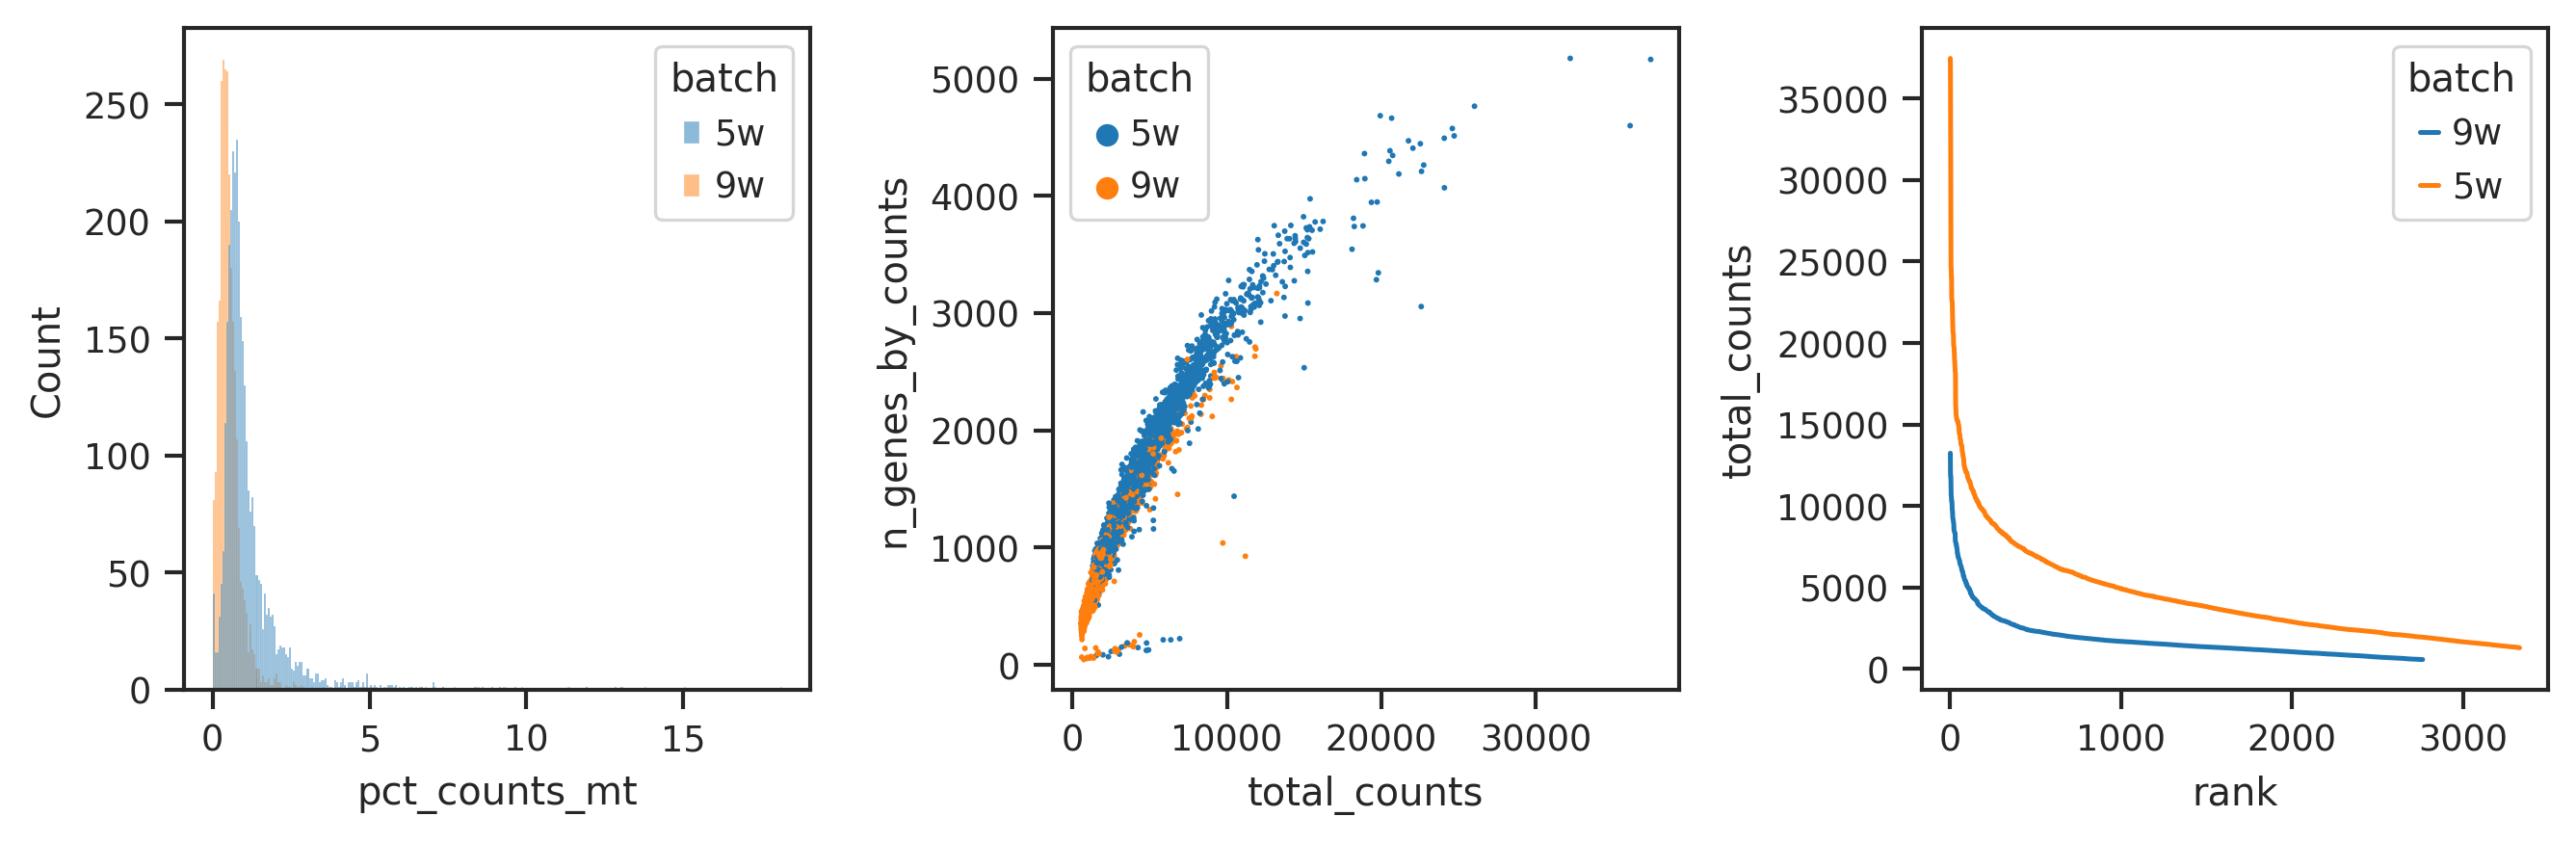

In [10]:
qc_plot(adata, show_thresh=False)

# Create pseudobulk signatures

In [11]:
def create_signature_matrix(adata, obs_key, save_path):
    signatures = pd.DataFrame(index=adata.var_names)
    for cell_type in adata.obs[obs_key].unique():
        signatures[cell_type] = list(pd.DataFrame(adata[adata.obs[obs_key] == cell_type].X.todense()).mean(axis=0))
    signatures.to_csv(save_path)
    return signatures

## Full atlas

In [12]:
signatures = create_signature_matrix(adata, "cell_types", "/notebook/Joe/M-cells/analysis/cell_type_signatures/skin_epithelium_coarse_signatures.csv")

In [13]:
signatures

,EPI,ANA,FIB,IMM,VASC,MEL,MISC,JUNK
Xkr4,0.002034,0.000000,0.003690,0.000000,0.000000,0.000000,0.000000,0.002683
Gm1992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm37381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rp1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rp1-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
AC168977.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PISD,0.146492,0.161987,0.065484,0.112920,0.070619,0.505889,0.000000,0.159981
DHRSX,0.158584,0.185584,0.130167,0.192384,0.180471,0.192784,0.039973,0.121906
Vmn2r122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
signatures = signatures[["EPI", "ANA", "FIB", "MEL"]]
signatures.columns = signatures.columns + "_skin.coarse"
signatures.to_csv("/notebook/Joe/M-cells/analysis/cell_type_signatures/skin_epithelium_coarse_signatures.csv")

In [15]:
signatures

,EPI_skin.coarse,ANA_skin.coarse,FIB_skin.coarse,MEL_skin.coarse
Xkr4,0.002034,0.000000,0.003690,0.000000
Gm1992,0.000000,0.000000,0.000000,0.000000
Gm37381,0.000000,0.000000,0.000000,0.000000
Rp1,0.000000,0.000000,0.000000,0.000000
Rp1-1,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
AC168977.1,0.000000,0.000000,0.000000,0.000000
PISD,0.146492,0.161987,0.065484,0.505889
DHRSX,0.158584,0.185584,0.130167,0.192784
Vmn2r122,0.000000,0.000000,0.000000,0.000000


In [16]:
signaturesFine = create_signature_matrix(adata, "cluster_ids", "/notebook/Joe/M-cells/analysis/cell_type_signatures/skin_epithelium_fine_signatures.csv")

In [17]:
signaturesFine.columns

Index(['IFE C', 'IFE B', 'IFE SB1', 'IFE SB2', 'uHF B', 'uHF SB', 'SG', 'OB',
       'HG', 'ORS SB', 'mCP', 'uCP', 'ORS B1', 'ORS B2', 'LPC', 'GL4', 'GL3',
       'GL2', 'GL1', 'MED1', 'MED2', 'MED3', 'CX1', 'CX2', 'CX3', 'CX4', 'CX5',
       'IRS1', 'ANA - 8', 'FIB4', 'FIB3', 'FIB2', 'FIB1', 'DS1', 'DS2', 'tDP',
       'TC', 'MC1', 'MC2', 'MC3', 'DC', 'LC', 'EC1', 'EC2', 'vSM', 'LV',
       'MEL1', 'MEL2', 'SC', 'RBC', 'SM', 'JUNK'],
      dtype='object')

In [18]:
signaturesFine = signaturesFine.drop(["RBC", "JUNK"], axis=1)
signaturesFine.columns = [i.replace(" ", ".") for i in signaturesFine.columns]
signaturesFine.columns = signaturesFine.columns + "_skin.fine"
signaturesFine.to_csv("/notebook/Joe/M-cells/analysis/cell_type_signatures/skin_epithelium_fine_signatures.csv")

In [19]:
signaturesFine

,IFE.C_skin.fine,IFE.B_skin.fine,IFE.SB1_skin.fine,IFE.SB2_skin.fine,uHF.B_skin.fine,uHF.SB_skin.fine,SG_skin.fine,OB_skin.fine,HG_skin.fine,ORS.SB_skin.fine,...,DC_skin.fine,LC_skin.fine,EC1_skin.fine,EC2_skin.fine,vSM_skin.fine,LV_skin.fine,MEL1_skin.fine,MEL2_skin.fine,SC_skin.fine,SM_skin.fine
Xkr4,0.000000,0.001904,0.006911,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm1992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gm37381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rp1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rp1-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PISD,0.133665,0.094021,0.173339,0.136462,0.187011,0.122689,1.608391,0.147245,0.048167,0.174924,...,0.077275,0.087512,0.039719,0.126759,0.000000,0.066235,0.303991,0.597266,0.136258,0.000000
DHRSX,0.209850,0.137708,0.147076,0.277527,0.128023,0.187229,0.355401,0.181049,0.084247,0.076730,...,0.133837,0.458063,0.185909,0.196779,0.121305,0.173720,0.110136,0.205321,0.185449,0.076046
Vmn2r122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
signaturesFine.columns

Index(['IFE.C_skin.fine', 'IFE.B_skin.fine', 'IFE.SB1_skin.fine',
       'IFE.SB2_skin.fine', 'uHF.B_skin.fine', 'uHF.SB_skin.fine',
       'SG_skin.fine', 'OB_skin.fine', 'HG_skin.fine', 'ORS.SB_skin.fine',
       'mCP_skin.fine', 'uCP_skin.fine', 'ORS.B1_skin.fine',
       'ORS.B2_skin.fine', 'LPC_skin.fine', 'GL4_skin.fine', 'GL3_skin.fine',
       'GL2_skin.fine', 'GL1_skin.fine', 'MED1_skin.fine', 'MED2_skin.fine',
       'MED3_skin.fine', 'CX1_skin.fine', 'CX2_skin.fine', 'CX3_skin.fine',
       'CX4_skin.fine', 'CX5_skin.fine', 'IRS1_skin.fine', 'ANA.-.8_skin.fine',
       'FIB4_skin.fine', 'FIB3_skin.fine', 'FIB2_skin.fine', 'FIB1_skin.fine',
       'DS1_skin.fine', 'DS2_skin.fine', 'tDP_skin.fine', 'TC_skin.fine',
       'MC1_skin.fine', 'MC2_skin.fine', 'MC3_skin.fine', 'DC_skin.fine',
       'LC_skin.fine', 'EC1_skin.fine', 'EC2_skin.fine', 'vSM_skin.fine',
       'LV_skin.fine', 'MEL1_skin.fine', 'MEL2_skin.fine', 'SC_skin.fine',
       'SM_skin.fine'],
      dtype='object'